## DTW Quickstart

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



<Axes: >

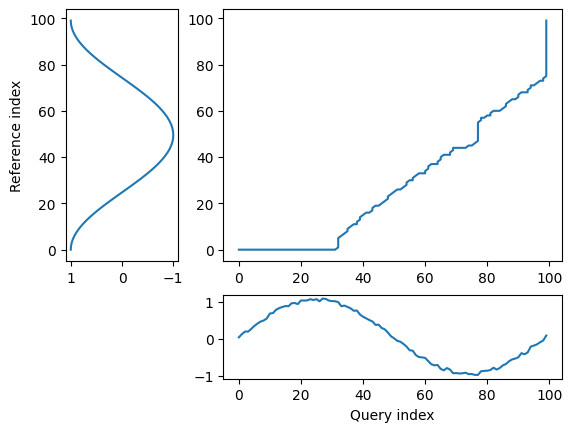

In [2]:
idx = np.linspace(0, 6.28, num=100)
query = np.sin(idx) + np.random.uniform(size=100) / 10.0

template = np.cos(idx)
alignment = dtw(query, template, keep_internals=True)

alignment.plot(type="threeway")

### DTW for time series in pose estimation

In [3]:
def group_dataframe(
    df: pd.DataFrame, group_column: str, columns_to_kepp: list[str]
) -> np.ndarray:
    df_groups = df.groupby(group_column)

    reference_data = []
    for _, group in df_groups:
        reference_data.append(group[columns_to_kepp].to_numpy())

    return np.array(reference_data)

In [4]:
POSITION_COLUMNS = ["x", "y", "z"]

reference_video_joints_df = pd.read_csv("../results/reference_squat/joints.csv")
reference_video_joints_df.head()

frame         x         y         z  visibility  joint_id
0      0  0.144358 -0.472796 -0.015095    0.999907        11
1      0 -0.148776 -0.481989 -0.136078    0.999985        12
2      0  0.217394 -0.293394 -0.111993    0.964206        13
3      0 -0.271390 -0.270867 -0.233686    0.996534        14
4      0  0.263808 -0.447081 -0.337177    0.983496        15

In [5]:
reference_data = group_dataframe(
    reference_video_joints_df, group_column="frame", columns_to_kepp=POSITION_COLUMNS
)

In [6]:
query_video_joints_df = pd.read_csv("../results/query_squat/joints.csv")
query_video_joints_df.head()

frame         x         y         z  visibility  joint_id
0      0  0.270567 -0.404950 -0.068237    0.999771        11
1      0  0.067789 -0.396084 -0.347861    0.999888        12
2      0  0.361893 -0.218562  0.019094    0.884555        13
3      0  0.071044 -0.144514 -0.360021    0.992676        14
4      0  0.557464 -0.072485 -0.034318    0.957719        15

In [7]:
query_data = group_dataframe(
    query_video_joints_df, group_column="frame", columns_to_kepp=POSITION_COLUMNS
)

Both datasets are now filtered and grouped. Let's assume only importance on one of the knees (right in this case).

In [8]:
reference_data_right_knee = reference_data[:, 9, :]
query_data_right_knee = query_data[:, 9, :]

In [9]:
def filter_repetable_reference_indexes(
    referene_to_query: np.ndarray, query_to_refernce: np.ndarray
) -> np.ndarray:
    query_to_refernce_cp = query_to_refernce.copy()
    for idx in range(len(referene_to_query) - 2, 1, -1):
        if referene_to_query[idx] == referene_to_query[idx + 1]:
            query_to_refernce_cp = np.delete(query_to_refernce_cp, idx)

    return query_to_refernce_cp

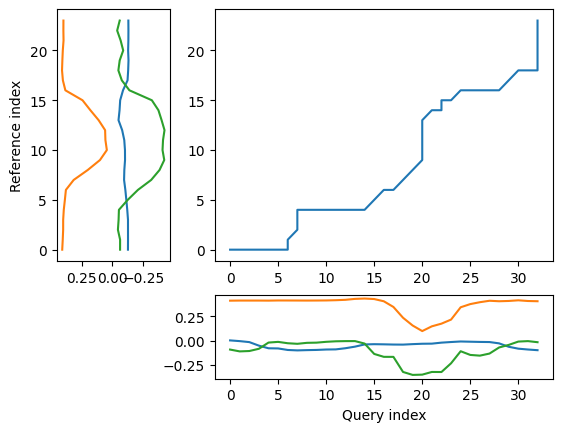

In [10]:
alignment = dtw(query_data_right_knee, reference_data_right_knee, keep_internals=True)
frames_warped = alignment.index1
reference_to_query_warped = alignment.index1
query_to_refernce_warped = alignment.index2
alignment.plot(type="threeway");

In [11]:
query_to_refernce_warped_frames = filter_repetable_reference_indexes(
    reference_to_query_warped, query_to_refernce_warped
)

Let's visualize that in 3D (Unfortunetly `dtw-python` allows only one dimention data for threeway plotting).

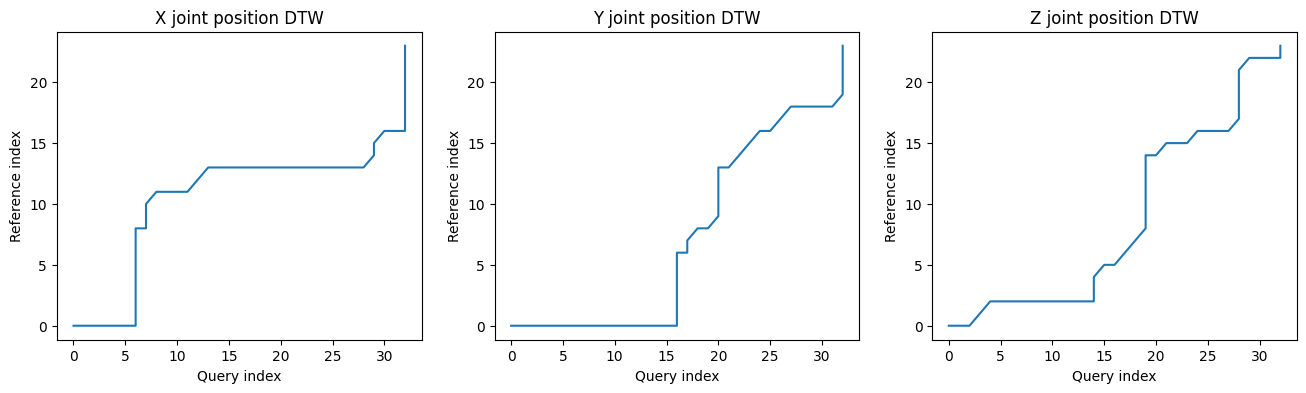

In [12]:
joints_positions = ["X", "Y", "Z"]

_, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for idx, axis in enumerate(axes):
    reference = reference_data[:, 9, idx]
    query = query_data[:, 9, idx]
    alignment = dtw(query, reference)
    axis.plot(alignment.index1, alignment.index2)
    axis.set_title(f"{joints_positions[idx]} joint position DTW")
    axis.set_xlabel("Query index")
    axis.set_ylabel("Reference index")

<Axes: xlabel='Index', ylabel='Query value'>

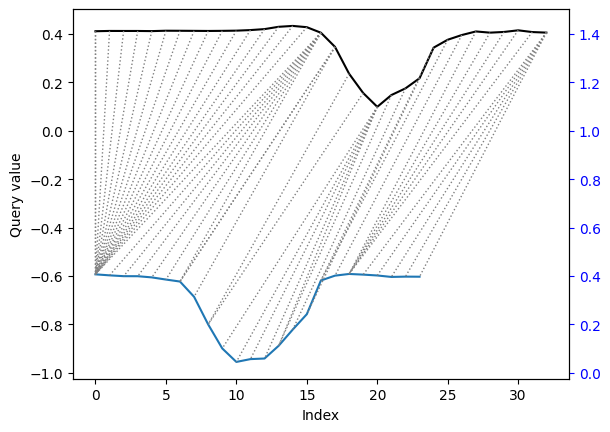

In [13]:
dtw(
    query_data_right_knee[:, 1], reference_data_right_knee[:, 1], keep_internals=True
).plot(type="twoway", offset=-1)

### Frames warping visualization

In [14]:
reference_vc = cv2.VideoCapture("../data/squat/reference_squat.mp4")
query_vc = cv2.VideoCapture("../data/squat/reference_squat_2.mp4")

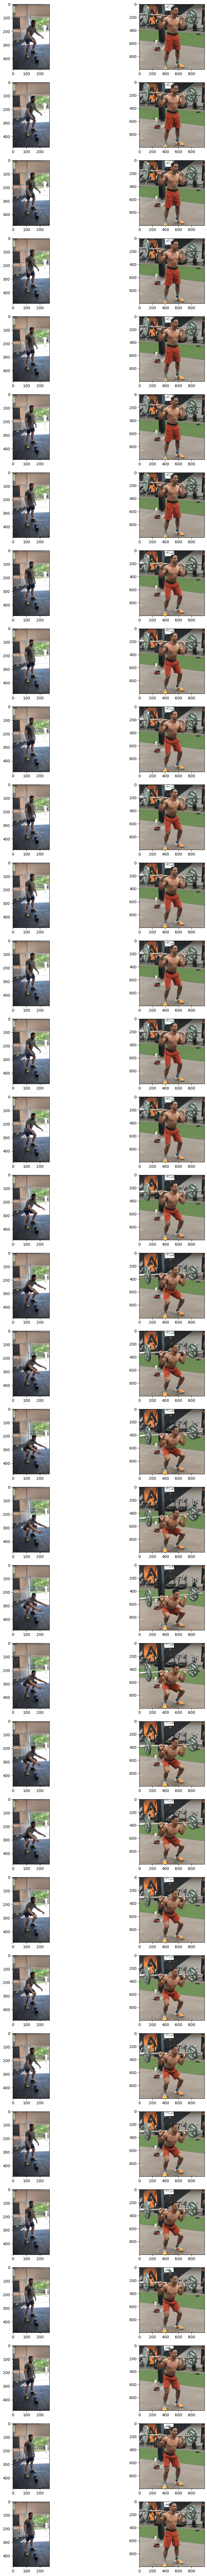

In [15]:
fig, axes = plt.subplots(nrows=len(query_data), ncols=2, figsize=(12, 120))

_, reference_frame = reference_vc.read()
reference_frame_id = 0

for (axis_query, axis_reference), warped_frame_id in zip(
    axes, query_to_refernce_warped_frames
):
    while warped_frame_id != reference_frame_id:
        _, reference_frame = reference_vc.read()
        reference_frame_id += 1

    _, query_frame = query_vc.read()
    axis_query.imshow(query_frame[..., ::-1])
    axis_reference.imshow(reference_frame[..., ::-1])